In [221]:
import os
import numpy as np
import re

In [222]:
class scan:
     def __init__(self):
        self.ID = "" 
        self.annealed = False
        self.reflection = "004"
        self.omega = []
        self.intensity = []
        self.fitted = fitted()

class fitted:
    def __init__(self):
        self.A = 0
        self.B = 0
        self.rho = 0
        self.f = 0

Here I just import all files as a list of structs (or classes, whatever)

In [223]:
projections_path = "Data/Projection_SiGePeak/"

regex = r"\d{5}"

scans = []

for fileID in os.listdir(projections_path):
    file = os.fsdecode(fileID)
    file = projections_path + file
    temp = scan()

    temp.ID = (re.findall(r'(?<!\d)(\d{5})(?!\d)', file))[0]

    if temp.ID == None:
        print("Sample ID is not known!")
        exit(1)

    if "annealed" in file:
        temp.annealed = True
    elif "as_grown":
        temp.annealed = False
    else:
        print("Error, not a known annealing state!")
        exit(1)

    if "004" in file:
        temp.reflection = "004"
    elif "224" in file:
         temp.reflection = "224"
    else:
        print("Error, not a known reflection!")
        exit(1)
    
    temp.omega, _, _, _, _, _, _, _, _, temp.intensity = np.genfromtxt(file, dtype=float, skip_header=7, unpack=True)

    scans.append(temp)


dictionary = {"11352" : "580C", "11354" : "520C", "11358" : "530C", "11355" : "550C","11371" : "510C"}
scans.sort(key=lambda x: dictionary[x.ID])



In [224]:
def shift_peak(scan):
    peak_el = scan.intensity.argmax()
    delta_omega = scan.omega - scan.omega[peak_el]
    scan.omega = delta_omega
    return scan

def normalize_intensity(scan):
    intensity_max = scan.intensity.max()
    scan.intensity = scan.intensity/intensity_max
    return scan

for scan in scans:
    if scan.ID == "11358":  # ID for 530C
        peak_el = scan.intensity.argmax()
        delta_omega = scan.omega - scan.omega[peak_el]
        scan.omega = delta_omega
        scan.omega = - scan.omega
        break
    

Text(0.5, 1.0, '004, Aligned Peaks, Normalized Intensities')

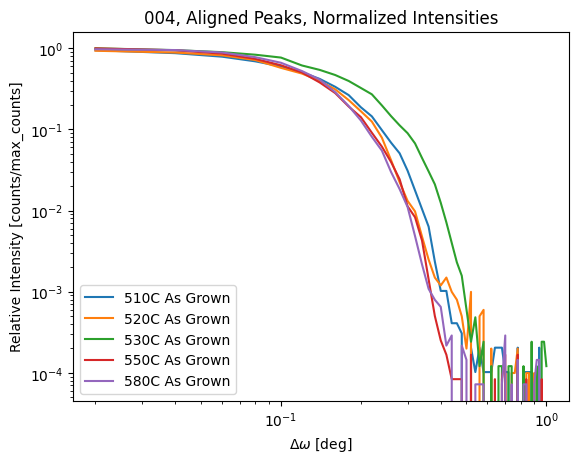

In [225]:
import matplotlib.pyplot as plt
from copy import deepcopy



for scan in scans:
    if scan.reflection == "004" and not scan.annealed:
        t = deepcopy(scan) # SUPER ugly but works
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("004, Aligned Peaks, Normalized Intensities")


Text(0.5, 1.0, '004, Aligned Peaks, Normalized Intensities')

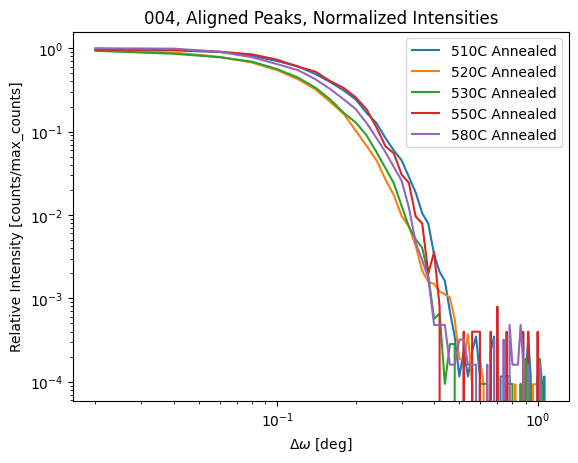

In [226]:
for scan in scans:
    if scan.reflection == "004" and scan.annealed:
        t = deepcopy(scan) # SUPER ugly but works
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("004, Aligned Peaks, Normalized Intensities")


Text(0.5, 1.0, '224, Aligned Peaks, Normalized Intensities')

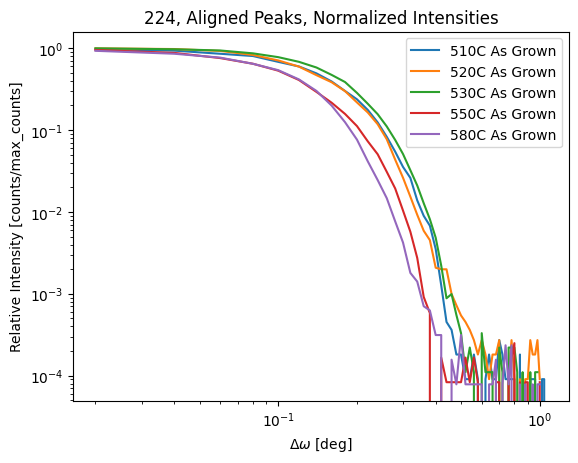

In [227]:
omega = np.linspace(0.2, 0.4, 10)

for scan in scans:
    if scan.reflection == "224" and not scan.annealed:
        t = deepcopy(scan)
        t = shift_peak(t)
        t = normalize_intensity(t)
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("224, Aligned Peaks, Normalized Intensities")


Text(0.5, 1.0, '224, Aligned Peaks, Normalized Intensities')

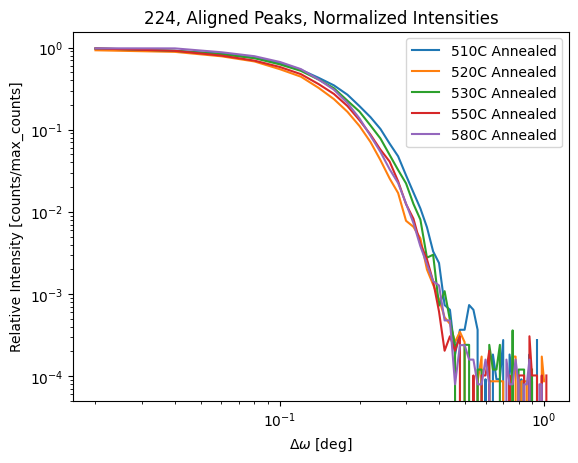

In [228]:
for scan in scans:
    if scan.reflection == "224" and scan.annealed:
        t = deepcopy(scan)
        t = shift_peak(t)
        t = normalize_intensity(t)
        if scan.ID == "11358": t.omega = -t.omega
        if scan.ID == "11371": t.omega = -t.omega
        if scan.ID == "11352": t.omega = -t.omega
        plt.loglog(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.legend()
plt.xlabel(r"$\Delta\omega$ [deg]")
plt.ylabel("Relative Intensity [counts/max_counts]")
plt.title("224, Aligned Peaks, Normalized Intensities")


A =  3.4390546584526513e-06 b =  7.893518309364436
A =  0.9990771549858103 b =  0.004241767983578986 sigma = 0.11521893963087426


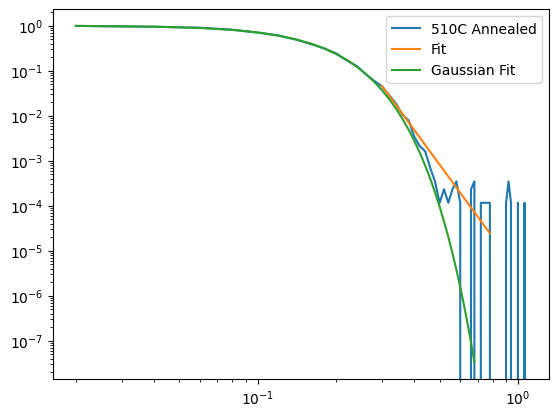

In [229]:
from scipy.optimize import curve_fit

t = deepcopy(scans[0])
t = shift_peak(t)
t = normalize_intensity(t)
f = lambda x,A,b: A* pow(x,-b)
set =(t.omega > 0.3) & (t.omega < 0.8)

gaussian = lambda x,A,b,c: A*np.exp(-pow(x-b,2)/(2*pow(c,2)))
setg = (t.omega > 0) & (t.omega < 0.7)

popvg, pcovg = curve_fit(gaussian, t.omega[setg], t.intensity[setg])
popv, pcov = curve_fit(f, t.omega[set], t.intensity[set])

plt.plot(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.plot(t.omega[set], f(t.omega[set], *popv), label = "Fit")
plt.plot(t.omega[setg], gaussian(t.omega[setg], *popvg), label = "Gaussian Fit")

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

print("A = ", popv[0], "b = ", popv[1])
print("A = ", popvg[0], "b = ", popvg[1], "sigma =", popvg[2])

A =  1.2083518959774521e-08 b =  11.039162256697548
A =  1.0874595840107302 b =  -0.033855849053155175 sigma = 0.10370484761726324


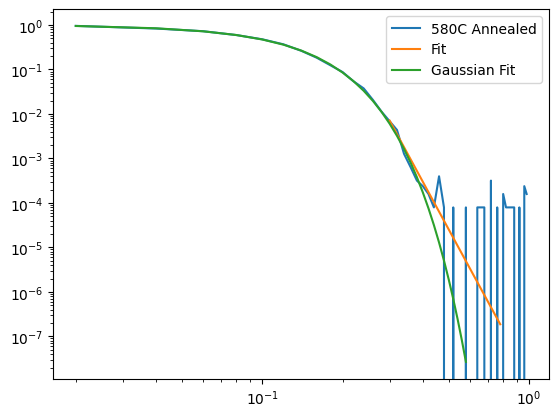

In [230]:
from scipy.optimize import curve_fit

t = deepcopy(scans[-1])
t = shift_peak(t)
t = normalize_intensity(t)
f = lambda x,A,b: A* pow(x,-b)
set =(t.omega > 0.3) & (t.omega < 0.8)

gaussian = lambda x,A,b,c: A*np.exp(-pow(x-b,2)/(2*pow(c,2)))
setg = (t.omega > 0) & (t.omega < 0.6)

popvg, pcovg = curve_fit(gaussian, t.omega[setg], t.intensity[setg])
popv, pcov = curve_fit(f, t.omega[set], t.intensity[set])

plt.plot(t.omega[t.omega>0], (t.intensity[t.omega> 0]), label = dictionary[t.ID] + (" Annealed" if t.annealed else " As Grown"))
plt.plot(t.omega[set], f(t.omega[set], *popv), label = "Fit")
plt.plot(t.omega[setg], gaussian(t.omega[setg], *popvg), label = "Gaussian Fit")

plt.legend()

ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')

print("A = ", popv[0], "b = ", popv[1])
print("A = ", popvg[0], "b = ", popvg[1], "sigma =", popvg[2])

Text(0.5, 1.0, 'Raw')

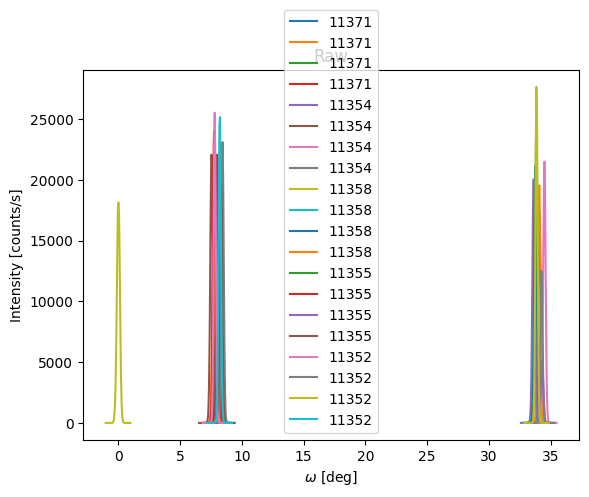

In [231]:
import matplotlib.pyplot as plt

for scan in scans:
    plt.plot(scan.omega, scan.intensity, label = scan.ID)
plt.legend()
plt.xlabel(r"$\omega$ [deg]")
plt.ylabel("Intensity [counts/s]")
plt.title("Raw")

In [232]:
def fit(scan): # Worng, just to test
    from scipy.optimize import curve_fit
    def lorentzian(x, A, B, rho, f):
        return A + B * (1/(1 + (4 * (x - rho)/f)**2))
    popt, pcov = curve_fit(lorentzian, scan.omega, scan.intensity)
    scan.fitted.A = popt[0]
    scan.fitted.B = popt[1]
    scan.fitted.rho = popt[2]
    scan.fitted.f = popt[3]
    return scan

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1000.

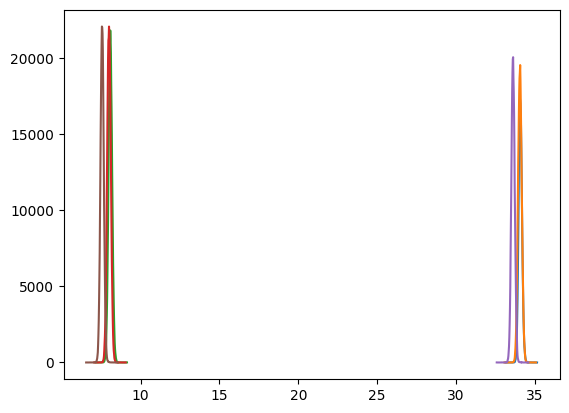

In [233]:
for scan in scans:
    fit(scan)
    plt.plot(scan.omega, scan.intensity, label = scan.ID)
    # Plot also fitted shape
plt.legend()
plt.xlabel(r"$\omega$ [deg]")
plt.ylabel("Intensity [counts/s]")
plt.title("Fitted")
    